# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

In [1]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

In [ ]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]

In [3]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor(
        [vocabulary[token] for token in tokenizer(text)], dtype=torch.long
    )

In [ ]:
from collections import Counter

tokenizer = get_tokenizer("basic_english")
vocabulary = vocab(
    Counter(token for text in tqdm(train_df["text"]) for token in tokenizer(text)),
    min_freq=10,
    specials=["<unk>", "<pad>"],
)
vocabulary.set_default_index(vocabulary["<unk>"])

text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

In [ ]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

In [6]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    for i in range(0, len(X), batch_size):
        batch_X = X[i : i + batch_size]
        batch_y = y[i : i + batch_size]
        max_len = max([len(x) for x in batch_X])
        batch_X = torch.stack(
            [
                torch.cat([torch.ones(max_len - len(x), dtype=torch.long) * pad_id, x])
                for x in batch_X
            ]
        )
        yield batch_X, torch.tensor(batch_y, dtype=torch.long)

In [7]:
pad_token = "<pad>"
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [9]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings."""

    def __init__(
        self,
        vocab_size: int,
        embed_size: int,
        hidden_size: int,
        n_layers: int,
        n_outputs: int,
    ) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size=self.embed_size,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,  # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]

        # Linear projection.
        out = self.fc(out)

        return out

## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [10]:
import copy


def train(
    model: nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses].
    """
    best_model = copy.deepcopy(model)
    best_loss = float("inf")
    train_losses = []
    valid_losses = []
    for _ in tqdm(range(n_epochs)):
        model.train()
        train_loss = 0.0
        for X, y in train_gen():
            X, y = X.to(device), y.to(device).float()
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred.squeeze(), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
        train_loss /= len(X_train)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for X, y in valid_gen():
                X, y = X.to(device), y.to(device).float()
                y_pred = model(X)
                loss = criterion(y_pred.squeeze(), y)
                valid_loss += loss.item() * X.size(0)
            valid_loss /= len(X_valid)
            valid_losses.append(valid_loss)
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_model = copy.deepcopy(model)
    return best_model, train_losses, valid_losses

In [11]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

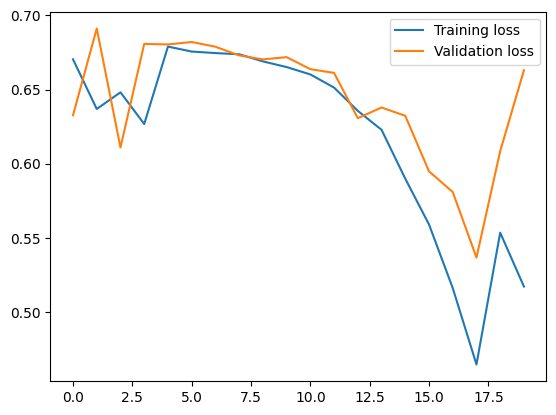

In [13]:
from matplotlib import pyplot as plt


plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)
* **\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.
* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).
* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

In [14]:
# Add an accuracy function and report the accuracy of the training, validation, and test set.
def accuracy(model: nn.Module, data_gen: Callable) -> float:
    """Compute the accuracy of a model.
    Args:
        model: a class inheriting from nn.Module.
        data_gen: a callable function returing a batch (data, labels).
    Returns:
        The accuracy of the model.
    """
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for X, y in data_gen():
            X, y = X.to(device), y.to(device).float()
            y_pred = model(X)
            y_pred = torch.sigmoid(y_pred)
            y_pred = torch.round(y_pred)
            correct += (y_pred.squeeze() == y).sum().item()
            total += y.size(0)
    return correct / total

In [15]:
print(f"Training accuracy: {accuracy(best_model, train_gen):.2f}")
print(f"Validation accuracy: {accuracy(best_model, valid_gen):.2f}")
print(f"Test accuracy: {accuracy(best_model, test_gen):.2f}")

Training accuracy: 0.81
Validation accuracy: 0.73
Test accuracy: 0.74


Results for PyTorch RNN:
* Accuracy on training set: 0.88
* Accuracy on validation set: 0.77
* Accuracy on test set: 0.77


#### Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.

In [16]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_size: int,
        hidden_size: int,
        n_layers: int,
        n_outputs: int,
    ):
        """Initialize a LSTM.
        Args:
            vocab_size: the size of the vocabulary.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The LSTM
        self.lstm = nn.LSTM(
            input_size=self.embed_size,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,  # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Forward pass of the LSTM.
        Args:
            X: the input data.
        Returns:
            The output of the LSTM.
        """
        # Embedding the input.
        out = self.embed(X)
        # LSTM
        out, _ = self.lstm(out)
        # Getting the last value only.
        out = out[:, -1, :]

        # Linear projection.
        out = self.fc(out)

        return out

  0%|          | 0/20 [00:00<?, ?it/s]

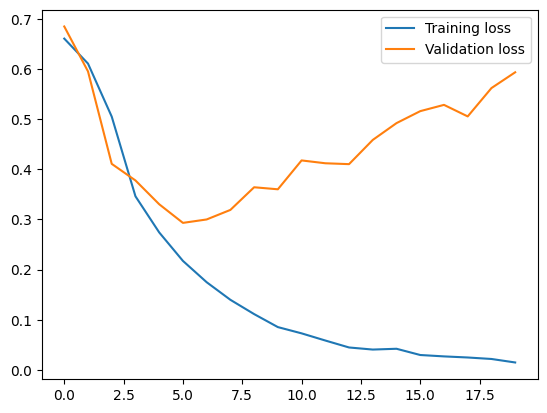

In [17]:
model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

best_model_lstm, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

In [18]:
print(f"Training accuracy: {accuracy(best_model_lstm, train_gen):.2f}")
print(f"Validation accuracy: {accuracy(best_model_lstm, valid_gen):.2f}")
print(f"Test accuracy: {accuracy(best_model_lstm, test_gen):.2f}")

Training accuracy: 0.94
Validation accuracy: 0.88
Test accuracy: 0.87


Results for PyTorch LSTM:
* Accuracy on training set: 0.94
* Accuracy on validation set: 0.88
* Accuracy on test set: 0.87

Results are way better with LSTM than with RNN. LSTM is better at remembering long term dependencies due to its memory cell. RNNs are better at remembering short term dependencies.

#### Implement a function which takes any text and returns the model's prediction.

In [23]:
def text_to_int(text: str, vocabulary: Dict[str, int]) -> List[int]:
    """Convert a text to a list of integers.
    Args:
        text: the text to convert.
        vocabulary: the vocabulary to use.
    Returns:
        The list of integers.
    """
    return [vocabulary[c] for c in text]


def predict(model: nn.Module, text: str) -> Tuple[int, float]:
    model.eval()
    with torch.no_grad():
        # Convert the text to a tensor.
        X = torch.tensor([text_to_int(text, vocabulary)]).to(device)
        # Forward pass.
        y_pred = model(X)
        y_pred = torch.sigmoid(y_pred)
        confidence = y_pred.squeeze().item()
        y_pred = torch.round(y_pred)
        # Get the class and the probability.
        y_pred = y_pred.item()
        return y_pred, confidence

In [24]:
# Test the function on a few examples.
print(predict(best_model_lstm, "I love this movie!"))
print(predict(best_model_lstm, "I hate this movie!"))
print(predict(best_model_lstm, "This movie is great!"))
print(predict(best_model_lstm, "This movie is bad!"))
print(predict(best_model_lstm, "What to think about this movie?"))

tensor([[-1.5489]])
(0.0, 0.17524296045303345)
tensor([[-0.5910]])
(0.0, 0.3564160466194153)
tensor([[0.2444]])
(1.0, 0.560808002948761)
tensor([[0.8074]])
(1.0, 0.6915622353553772)
tensor([[-0.8316]])
(0.0, 0.3033004105091095)


#### Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.

In [25]:
class BiLSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_size: int,
        hidden_size: int,
        n_layers: int,
        n_outputs: int,
    ):
        """Initialize a BiLSTM.
        Args:
            vocab_size: the size of the vocabulary.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The BiLSTM
        self.lstm = nn.LSTM(
            input_size=self.embed_size,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,  # Changes the order of dimension to put the batches first.
            bidirectional=True,
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size * 2, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Forward pass of the BiLSTM.
        Args:
            X: the input data.
        Returns:
            The output of the BiLSTM.
        """
        # we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
        # Embedding the input.
        out = self.embed(X)
        # BiLSTM
        out, _ = self.lstm(out)
        # Getting the last value only.
        out = torch.cat(
            (out[:, -1, : self.hidden_size], out[:, 0, self.hidden_size :]), dim=1
        )
        # Linear projection.
        out = self.fc(out)

        return out

  0%|          | 0/20 [00:00<?, ?it/s]

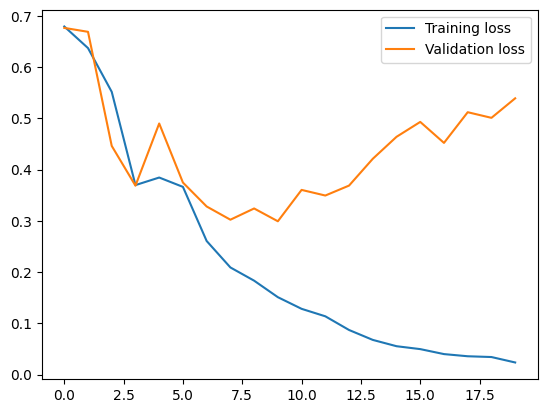

In [26]:
model = BiLSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

best_model_bilstm, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

In [27]:
print(f"Training accuracy: {accuracy(best_model_bilstm, train_gen):.2f}")
print(f"Validation accuracy: {accuracy(best_model_bilstm, valid_gen):.2f}")
print(f"Test accuracy: {accuracy(best_model_bilstm, test_gen):.2f}")

Training accuracy: 0.96
Validation accuracy: 0.88
Test accuracy: 0.88


Results for PyTorch BiLSTM:
* Accuracy on training set: 0.96
* Accuracy on validation set: 0.88
* Accuracy on test set: 0.88

BiLSTM is slightly better than LSTM. This is predictable as BiLSTM is a combination of two LSTMs, one going forward and one going backward. This allows the model to remember both short and long term dependencies.

#### Look at two wrongly classified examples on the test set. Try explaining why the model was wrong.

In [28]:
def get_wrong_predictions(
    model: nn.Module, generator: Callable
) -> List[Tuple[str, int, float]]:
    """Get the wrong predictions of a model.
    Args:
        model: the model to use.
        generator: the generator to use.
    Returns:
        The wrong predictions.
    """
    wrong_predictions = []
    for X, y in generator():
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        for i in range(len(y)):
            if y_pred[i] != y[i]:
                wrong_predictions.append(
                    (
                        " ".join(
                            filter(
                                lambda t: t != pad_token,
                                vocabulary.lookup_tokens(X[i].tolist()),
                            )
                        ),
                        int(y[i]),
                        y_pred[i].item(),
                    )
                )
    return wrong_predictions


wrong_predictions = get_wrong_predictions(best_model_bilstm, test_gen)

for text, y, y_pred in wrong_predictions[:2]:
    print(f"Text: {text}")
    print(f"True class: {y}")
    print(f"Predicted class: {y_pred}")
    print()

Text: the <unk> color cinematography of leon <unk> is quite remarkable here , including his use of colored filters for various scenes . the alfred <unk> score has to be the most sensual and seductive score hollywood ever produced . it ' s a shame it is no longer available on cd . the actors , however , never rise to the occasion . the accents are so varied , from the subdued british of ustinov and <unk> to the hollywood of baxter and mature that it seems a true hodgepodge with no central vision . tommy <unk> is <unk> american . acting styles span the range from <unk> to stilted . only ustinov as a conniving <unk> servant steals the show - what there is of it to steal . the premise - the story of a young egyptian doctor , seduced and abandoned by the rich - and the parallel theme of the cult of the single god , ra - persecuted by the authorities , has its interesting points . but when the film ' s plot fades , it is the haunting music and visuals that remain .
True class: 0
Predicted cl

Here are the two wrongly classified examples (preprocessed):
- "*the <unk> color cinematography of leon <unk> is quite remarkable here , including his use of colored filters for various scenes . the alfred <unk> score has to be the most sensual and seductive score hollywood ever produced . it ' s a shame it is no longer available on cd . the actors , however , never rise to the occasion . the accents are so varied , from the subdued british of ustinov and <unk> to the hollywood of baxter and mature that it seems a true hodgepodge with no central vision . tommy <unk> is <unk> american . acting styles span the range from <unk> to stilted . only ustinov as a conniving <unk> servant steals the show - what there is of it to steal . the premise - the story of a young egyptian doctor , seduced and abandoned by the rich - and the parallel theme of the cult of the single god , ra - persecuted by the authorities , has its interesting points . but when the film ' s plot fades , it is the haunting music and visuals that remain .*"
- "*perhaps it ' s just the format of this film , a documentary , but i believe that the movie would have been much better served by good actors and more solid dialogue . the fact that the actors are also the business owners is a <unk> sword . they know better than anyone else the emotions and complexities of the business they were in , but , since they are not professional actors , they do a very poor job of conveying those emotions and the documentary suffers . there were some truly memorable scenes in this movie and lots of good lines but they were delivered so poorly that they will fade away with time and the only memory i will have of this documentary is that it had some good scenes which i can ' t remember . watch this if you want a <unk> account of the . com bust and see what happened to the 99% of people in the industry who didn ' t become instant <unk> . however , be prepared for some nauseating camera work , poor acting , poor dialogue , and an overall bad movie that <unk> the era of the internet boom .*"

Both are classified as negative while they are positive.
The first example could be confusing because it's not really biased towards positive or negative. It's more of a neutral review. The fact that we are using a BiLSTM and that must of the "negative" words are in the middle of the review could explain why the model is wrong.
The second example is strange because it's clearly not a positive review. Maybe this sample has been mislabeled, because it doesn't look like the model is wrong here.

In [29]:
torch.save(best_model, "best_model_torch.pt")
torch.save(best_model_lstm, "best_model_lstm.pt")
torch.save(best_model_bilstm, "best_model_bilstm.pt")